# Transformer architecture on SIGNUM Dataset

In [1]:
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn import functional as F
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import math

This shows the transformer classifier model which accepts a time series data as input

In [2]:
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=4, hidden_dim=256, dropout=0.1):
        super(TransformerClassifier, self).__init__()
        
        self.input_dim = input_dim
        self.num_classes = num_classes
        
        # Transformer encoder layer
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=input_dim,  # Input dimension (features per frame)
            nhead=num_heads,    # Number of attention heads
            dim_feedforward=hidden_dim,  # Feedforward hidden layer size
            dropout=dropout
        )
        
        # Stacked transformer encoder
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layers, num_layers=num_layers
        )
        
        # Classifier head
        self.fc = nn.Linear(input_dim, num_classes)  # Final layer to output class probabilities
    
    def forward(self, x):
        """
        x: (batch_size, time_steps, features)
        """
        # Transformer expects input of shape (sequence_length, batch_size, input_dim)
        x = x.permute(1, 0, 2)  # Shape: (time_steps, batch_size, features)
        
        # Apply transformer encoder
        transformer_out = self.transformer_encoder(x)
        
        # We take the output of the last time step (or average pooling across time)
        # For simplicity, let's use the last time step output (as a representation of the sequence)
        x = transformer_out[-1, :, :]  # Shape: (batch_size, features)
        
        # Classifier head to predict the class
        x = self.fc(x)
        return x

Code for the training of the transformer followed by validation steps. It also plots the loss and accuracy curves for training and validation

In [3]:
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt
import numpy as np

def train_model(model, train_loader, val_loader, device, epochs=10, lr=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    model.to(device)
    
    # Lists to store metrics for plotting
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]', 
                         file=sys.stdout, leave=True)
        
        for X_batch, y_batch in train_pbar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            running_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            
            epoch_loss = running_loss / (train_pbar.n + 1)
            epoch_acc = 100 * correct / total
            train_pbar.set_postfix({
                'loss': f'{epoch_loss:.4f}',
                'acc': f'{epoch_acc:.2f}%'
            })

        train_pbar.close()
        
        # Store training metrics
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation step
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Valid]', 
                       file=sys.stdout, leave=True)
        
        with torch.no_grad():
            for X_batch, y_batch in val_pbar:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                val_total += y_batch.size(0)
                val_correct += (predicted == y_batch).sum().item()
                
                current_val_loss = val_loss / (val_pbar.n + 1)
                val_acc = 100 * val_correct / val_total
                val_pbar.set_postfix({
                    'loss': f'{current_val_loss:.4f}',
                    'acc': f'{val_acc:.2f}%'
                })

        val_pbar.close()
        
        # Store validation metrics
        val_losses.append(current_val_loss)
        val_accuracies.append(val_acc)
        
        print(f"\nEpoch {epoch+1}/{epochs} Summary:")
        print(f"Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")
        print(f"Validation Loss: {current_val_loss:.4f}, Accuracy: {val_acc:.2f}%\n")

    # Plot training history
    epochs_range = range(1, epochs + 1)
    
    # Create figure with two subplots
    plt.figure(figsize=(12, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs_range, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs_range, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Return history dictionary for further analysis if needed
    history = {
        'train_loss': train_losses,
        'train_acc': train_accuracies,
        'val_loss': val_losses,
        'val_acc': val_accuracies
    }
    
    return history

From the signum data we extract data for both hands only and leave out the pose since most of sign language data lies in the hands. This cell first extract data from the numpy files and then extracts data for both hands. Tha shape of training, validation and testing set is printed

In [4]:
def extract_both_hand(sequence_data):
    """Extract right hand landmarks from the full sequence data.
   
    Assumes sequence_data has shape (window_size, num_channels),
    where num_channels = 225 and the right hand occupies 63 channels.
    """
    both_hand_start = 33 * 3  # (33 pose + 21 left hand) * 3 coordinates
    both_hand_end = both_hand_start + 126  # 21 landmarks * 3 coordinates
    return sequence_data[:,:, both_hand_start:both_hand_end]
 
class SignumDataset(Dataset):
    def __init__(self, data_path, split):
        self.X = np.load(os.path.join(data_path, f'X_{split}.npy'))
        self.y = np.load(os.path.join(data_path, f'y_{split}.npy'))
        print(self.X.shape)
        self.X = extract_both_hand(self.X)
        print(self.X.shape)
   
    def __len__(self):
        return len(self.X)
   
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)
 
def get_dataloader(data_path, split, batch_size):
    dataset = SignumDataset(data_path, split)
   
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)
 
# Create train, validation, and test loaders
def get_all_dataloaders(data_path, batch_size):
    train_loader = get_dataloader(data_path, 'train', batch_size)
    val_loader = get_dataloader(data_path, 'val', batch_size)
    test_loader = get_dataloader(data_path, 'test', batch_size)
    return train_loader, val_loader, test_loader

folder_path = '../data/Signum_numpy' 
train_loader, val_loader, test_loader = get_all_dataloaders(folder_path, batch_size=16)

(6300, 80, 225)
(6300, 80, 126)
(1800, 80, 225)
(1800, 80, 126)
(1901, 80, 225)
(1901, 80, 126)


### Train model

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 1/400 [Valid]: 100%|██████████| 113/113 [00:00<00:00, 319.16it/s, loss=7.0672, acc=0.39%] 

Epoch 1/400 Summary:
Training Loss: 6.3667, Accuracy: 0.17%
Validation Loss: 7.0672, Accuracy: 0.39%

Epoch 2/400 [Valid]: 100%|██████████| 113/113 [00:00<00:00, 320.08it/s, loss=6.5481, acc=0.72%] 

Epoch 2/400 Summary:
Training Loss: 5.9984, Accuracy: 0.57%
Validation Loss: 6.5481, Accuracy: 0.72%

Epoch 3/400 [Valid]: 100%|██████████| 113/113 [00:00<00:00, 303.53it/s, loss=6.3892, acc=1.44%] 

Epoch 3/400 Summary:
Training Loss: 5.7433, Accuracy: 0.89%
Validation Loss: 6.3892, Accuracy: 1.44%

Epoch 4/400 [Valid]: 100%|██████████| 113/113 [00:00<00:00, 315.99it/s, loss=6.1096, acc=2.83%] 

Epoch 4/400 Summary:
Training Loss: 5.4750, Accuracy: 1.87%
Validation Loss: 6.1096, Accuracy: 2.83%

Epoch 5/400 [Valid]: 100%|██████████| 113/113 [00:00<00:00, 317.59it/s, loss=5.7528, acc=4.17%] 

Epoch 5/400 Summary:
Training Loss: 5.2189, Accuracy: 3.19%
Validation Loss: 5.7528, Accuracy: 4.17%



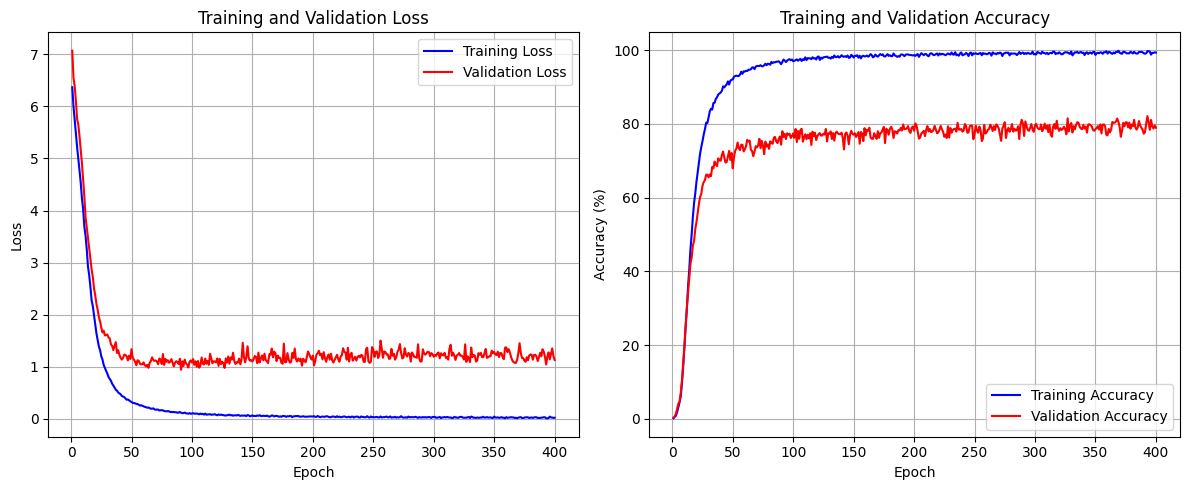

Test Accuracy: 86.90%


In [5]:
input_dim = 126  # Number of features (channels)
seq_length = 80
all_labels = np.array([label for _, label in train_loader.dataset])
num_classes = len(np.unique(all_labels))
num_heads = 9
print(num_classes)

# Initialize model
model = TransformerClassifier(input_dim=input_dim, num_heads = 9, num_classes=num_classes)
print(model)

# Select device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the model
train_model(model, train_loader, val_loader, device=device, epochs=400, lr=1e-4)

# Test the model on test data
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move data to device
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


## Generate classification report and confusion matrix

Total inference time: 286.07 ms
Inference time per instance: 0.15 ms

Classification Report:
              precision    recall  f1-score   support

           0      0.667     1.000     0.800         4
           1      1.000     1.000     1.000         5
           2      1.000     1.000     1.000         4
           3      1.000     1.000     1.000         5
           4      1.000     1.000     1.000         5
           5      1.000     1.000     1.000         5
           6      1.000     1.000     1.000         4
           7      1.000     1.000     1.000         4
           8      1.000     0.750     0.857         4
           9      1.000     1.000     1.000         4
          10      1.000     0.800     0.889         5
          11      0.667     1.000     0.800         4
          12      1.000     1.000     1.000         4
          13      0.800     1.000     0.889         4
          14      1.000     1.000     1.000         4
          15      1.000     1.000     1.00

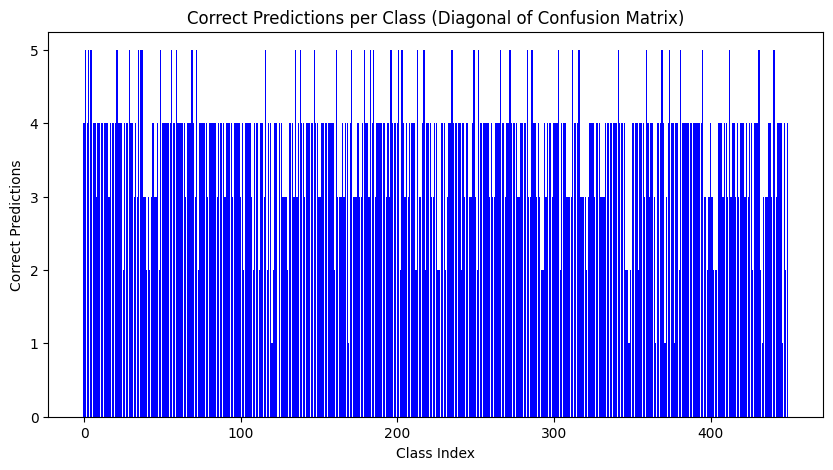

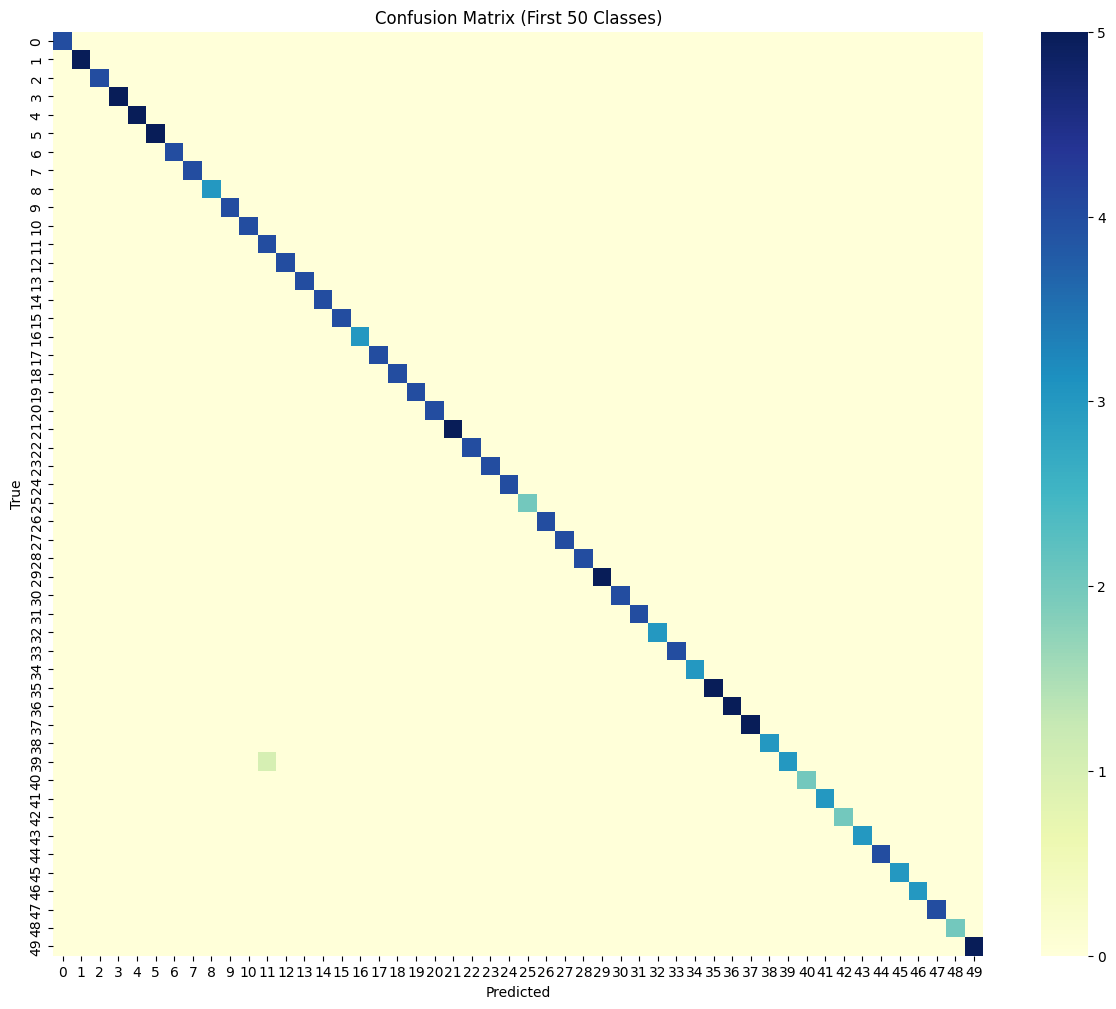

In [6]:
import time

model.eval()
true_labels = []
predicted_labels = []
total_instances = 0
start_time = time.time()

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        batch_size = X_batch.size(0)
        total_instances += batch_size
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(y_batch.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

end_time = time.time()
total_time_ms = (end_time - start_time) * 1000  # Convert to milliseconds
per_instance_time_ms = total_time_ms / total_instances

# Print inference time information
print(f"Total inference time: {total_time_ms:.2f} ms")
print(f"Inference time per instance: {per_instance_time_ms:.2f} ms")

# Classification Report
print("\nClassification Report:")
report = classification_report(true_labels, predicted_labels, zero_division=0, digits=3)
print(report)

# Confusion Matrix (optional for large datasets)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualizing diagonal counts for correct predictions
diag_counts = np.diag(conf_matrix)
plt.figure(figsize=(10, 5))
plt.bar(range(len(diag_counts)), diag_counts, color='blue')
plt.xlabel("Class Index")
plt.ylabel("Correct Predictions")
plt.title("Correct Predictions per Class (Diagonal of Confusion Matrix)")
plt.show()

# Heatmap for confusion matrix (cropped or full)
plt.figure(figsize=(15, 12))
sns.heatmap(conf_matrix[:50, :50], annot=False, fmt='d', cmap="YlGnBu")
plt.title("Confusion Matrix (First 50 Classes)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()